In [3]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import  numpy as np 
from PIL import  Image, ImageFont, ImageDraw
import  os

In [20]:
class Captha2Word(object):
    
    def __init__(self, k):
        self.k = k
    
    def run(self, img_path):
        img, PIL_img = self.get_img(img_path)
        centers = self.Kmeans(img)
        self.plot_centers(PIL_img,centers)
        self.test(img, centers)
    
    def test(self, img, centers):
        plt.imshow(img,cmap='gray') 
        plt.show()
        count = np.sum(img == 0,axis= 0)
        left_boundary,right_boundary = 0,0
        for i in range(img.shape[1]):
            if count[i] != 0 :
                left_boundary = i
                break
        for i in range(img.shape[1]-1,-1,-1):
            if count[i] != 0 :
                right_boundary = i
                break
        # print(left, right)
        min_weight = (right_boundary - left_boundary)//self.k//4
        for i in range(self.k - 1):
            
            left = centers[i][1] +min_weight
            right = centers[i+1][1] - min_weight
            print(left, right,type(right),type(centers[i][1]), type(min_weight))
            minx = np.argmin(count[left:right])
            
        
        
    
    def Kmeans(self,img):
        X = self.get_black_point(img)
        plt.figure(figsize=(10,2))
        km = KMeans(n_clusters=self.k)
        y_pred = km.fit_predict(X)
        centers = km.cluster_centers_
        centers = np.asarray(centers,dtype = np.int16)
        centers = centers[np.argsort(centers[:,1])]
        print(centers)
        plt.scatter(X[:,1], 88-X[:,0], c = y_pred, linewidths=0.01)
        plt.scatter(centers[:,1],88-centers[:,0],c='r', linewidths= 10)
        count = np.sum(img == 0,axis= 0)
        plt.plot(count,'b')
        plt.show()
        return  centers
        
    def plot_centers(self, PIL_img, centers):
        im = PIL_img.copy()
        bgdr = ImageDraw.Draw(im)
        for y, x in centers:
            bgdr.ellipse((x-3, y-3, x+3, y+3), fill ="red", outline ='red')
        # im.show()
        # print(im) 
        
    def split(self,img):
        pass
        
    def get_img(self,img_path):
        PIL_img = Image.open(img_path)
        img =np.asarray(PIL_img.convert("L"))#转化为灰度图像 
        img.setflags(write=1)
        # plt.imshow(img,cmap="gray")
        # plt.show()
        # uniques, counts = np.unique(img, return_counts=True)
        # print(uniques)
        # plt.scatter(uniques, counts)
        # plt.show()
        img[img<=150] = 0
        img[img>150]=255
        # plt.imshow(img,cmap="gray")
        # plt.show()
        
        return img, PIL_img.convert('RGB')
    
    def get_black_point(self, img):
        len = np.sum(img == 0)
        X = np.zeros((len,2))
        cnt = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] == 0:
                    X[cnt,0],X[cnt,1] = i,j
                    cnt =cnt +1
        return X
        
        

[[ 48  37]
 [ 47  81]
 [ 42 128]
 [ 58 179]
 [ 56 226]
 [ 46 262]
 [ 49 306]]
48 70 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
92 117 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
139 168 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
190 215 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
237 251 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
273 295 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
[[ 54  45]
 [ 49  95]
 [ 46 141]
 [ 50 179]
 [ 50 230]
 [ 48 275]
 [ 45 322]]
56 84 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
106 130 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
152 168 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
190 219 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
241 264 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
286 311 <class 'numpy.int32'> <class 'numpy.int16'> <class 'int'>
[[ 53  37]
 [ 48  73]
 [ 45 121]
 [ 52 160]
 [ 47 206]
 [

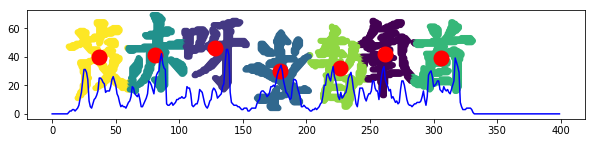

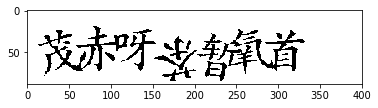

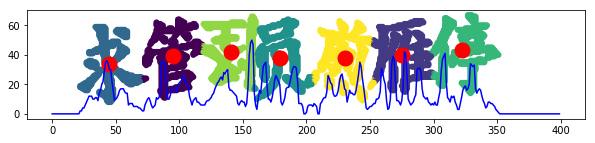

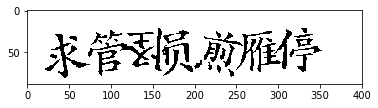

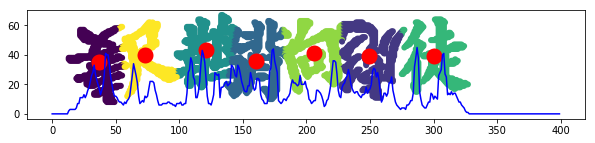

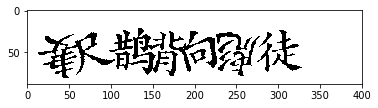

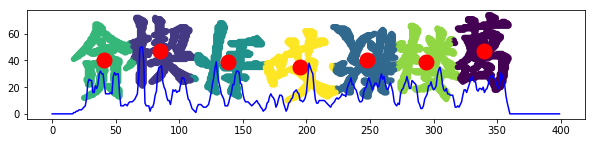

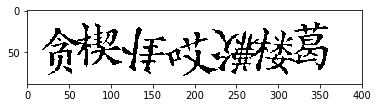

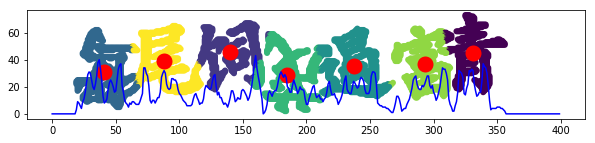

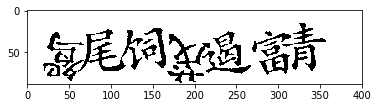

In [21]:
img_dir = r'.\CaptchaData'
k = 7#字符个数
get_word = Captha2Word(k)
for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    get_word.run(img_path)